# Keyrir Strætó of hratt?: Samanburður keyrsluhraðagagna frá Strætó API-inu við hámarkshraðagögn

_**Árni Dagur Guðmundsson**: arni@dagur.eu | Menntaskólinn við Hamrahlíð_

## Inngangur:

### API
Falið í kóða heimasíðu Strætó má finna API (forritaskil) sem geyma ýmsar upplýsingar um staka strætisvagna í rauntíma. Strætó appið notar þetta API meðal annars til að sýna staðsetningu strætisvagna á korti. Ég bjó til einfaldan Python pakka sem kallar á API-ið og spýtir út niðurstöðunum í JSON. Hér fyrir neðan sést niðurstaða einfalds kalls:

In [1]:
from straeto import straeto
straeto.getBusPositionsFor(["55"])[0]

{'deviceNumber': 206,
 'gpsFix': 2,
 'gpsTime': '180509180440',
 'heading': 149.14,
 'lastStop': 20000008,
 'lat': 64.0005383333333,
 'lon': -22.5594,
 'nextStop': 20000133,
 'pingCode': 6,
 'route': '55-C',
 'routeNumber': '55',
 'speed': 26.28}

Eins og sést býður API-ið upp á breiddargráðu (_lat_), og lengdargráðu (_lon_). Því er til dæmis hægt að birta staðsetningu allra strætisvagna landsins á kort líkt og svo:

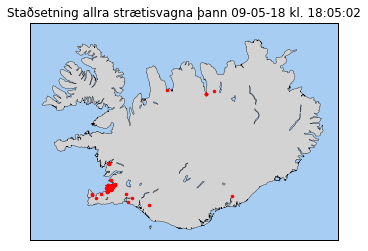

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import warnings; warnings.filterwarnings('ignore')
from datetime import datetime

map = Basemap(projection='merc', resolution='h', urcrnrlat=66.8, urcrnrlon=-12.9, llcrnrlat=63.2, llcrnrlon=-25)
map.drawcoastlines(linewidth=0.35)
map.fillcontinents(color='lightgrey', lake_color='#a7cdf2')
map.drawmapboundary(fill_color='#a7cdf2')

for bus in straeto.getAllBusPositions():
    X, Y = map(bus['lon'], bus['lat'])
    map.plot(X, Y, 'ro', markersize=2.5)

plt.title('Staðsetning allra strætisvagna þann {}'.format(datetime.now().strftime('%d-%m-%y kl. %H:%M:%S')))
plt.show()

Hraðinn er einnig til staðar en ekki vitum við þó hvaða mælieining notuð er til þess að mæla hann.

$k\cdot v_{api} = v \Rightarrow k = \frac{v}{v_{api}}$

In [52]:
# TODO: Færa úr notebook
import time
from datetime import datetime as dt
from geopy.distance import vincenty

p_buses = straeto.getAllBusPositions()

p_bdict = dict()
for pb in p_buses:
    p_bdict[pb['deviceNumber']] = {'gpsTime':pb['gpsTime'], 'lat':pb['lat'], 'lon':pb['lon'], 'speed':pb['speed']}

bdict = dict()
while True:
    buses = straeto.getAllBusPositions()

    for pb in p_buses:
        did = pb['deviceNumber']
        try:
            b = next(b for b in buses if b['deviceNumber'] == did)
        except:
            continue
        if (
        b['gpsTime'] != pb['gpsTime']
        and b['lat'] != pb['lat'] and b['lon'] != pb['lon']
        and b['speed'] > 2 and pb['speed'] > 2
        ):
            bdict[did] = {'gpsTime':b['gpsTime'], 'lat':b['lat'], 'lon':b['lon'], 'speed':b['speed'], 'route':b['route']}
    
    if (1/2)*len(p_bdict) < len(bdict):
        break
    time.sleep(1)
print(len(bdict))

42


In [53]:
G = []
B = []
Ks = []
for key in bdict:
    bus = bdict[key]; p_bus = p_bdict[key]
    t_1 = dt.strptime(bus['gpsTime'],"%y%m%d%H%M%S"); t_2 = dt.strptime(p_bus['gpsTime'],"%y%m%d%H%M%S")
    delta_t = (t_1-t_2).total_seconds()
    delta_s = vincenty((bus['lat'], bus['lon']), (p_bus['lat'], p_bus['lon'])).km

    kmh = (delta_s/delta_t)*3600
    avg_speed = (1/2)*(bus['speed']+p_bus['speed'])

    k = kmh/avg_speed
    Ks.append(k)
    dic = {
        'speed_0': p_bus['speed'],
        'speed_1': bus['speed'],
        'delta_s': delta_s,
        'delta_t': delta_t,
        'kmh': kmh,
        'avg_speed': avg_speed,
        'route': bus['route'],
        'k': k
    }
    if 1.7 < k < 1.9:
        G.append(dic)
    else:
        B.append(dic)

print('Good:')
for i in G:
    print('{} | kmh = {} / {} = {} | {} --> {}'.format(
        i['route'], round(i['delta_s'], 2), i['delta_t'], round(i['kmh'], 2), i['speed_0'], i['speed_1']
    ))
print('Bad:')
for i in B:
    print('{} | kmh = {} / {} = {} | {} --> {}'.format(
        i['route'], round(i['delta_s'], 2), i['delta_t'], round(i['kmh'], 2), i['speed_0'], i['speed_1']
    ))
avg_k = sum(Ks)/len(Ks)
print(avg_k)


Good:
13-A | kmh = 0.15 / 13.0 = 40.51 | 21.52 --> 22.52
36-A | kmh = 0.17 / 10.0 = 62.42 | 34.66 --> 32.04
59-A | kmh = 0.18 / 8.0 = 81.9 | 43.86 --> 44.6
57-A | kmh = 0.18 / 8.0 = 81.29 | 45.27 --> 42.59
57-C | kmh = 0.21 / 8.0 = 94.2 | 48.76 --> 54.57
31-B | kmh = 0.12 / 9.0 = 46.17 | 25.34 --> 27.68
18-A | kmh = 0.09 / 9.0 = 36.47 | 18.84 --> 20.31
51-A | kmh = 0.2 / 8.0 = 92.25 | 50.28 --> 49.36
55-A | kmh = 0.18 / 8.0 = 82.91 | 44.79 --> 43.92
82-A | kmh = 0.17 / 8.0 = 78.49 | 42.96 --> 41.72
2-C | kmh = 0.02 / 5.0 = 17.61 | 7.95 --> 12.2
2-B | kmh = 0.06 / 4.0 = 50.78 | 29.39 --> 24.32
6-C | kmh = 0.03 / 5.0 = 22.3 | 11.89 --> 13.59
55-B | kmh = 0.25 / 9.0 = 98.7 | 53.34 --> 53.11
6-B | kmh = 0.06 / 11.0 = 19.74 | 14.14 --> 8.01
57-D | kmh = 0.06 / 8.0 = 28.24 | 11.82 --> 18.92
43-D | kmh = 0.06 / 10.0 = 21.18 | 13.4 --> 9.92
3-B | kmh = 0.1 / 10.0 = 34.63 | 24.65 --> 12.52
24-B | kmh = 0.19 / 10.0 = 67.06 | 35.05 --> 36.21
16-A | kmh = 0.11 / 8.0 = 50.54 | 28.15 --> 27.37
28-B 

## Undirbúningur gagna:

```
ALTER TABLE buses ADD COLUMN geom Geometry(Point, 4326);
```
svo:
```
UPDATE buses SET geom=ST_SetSrid(ST_MakePoint(lon, lat), 4326);
```

```
SELECT r.maxspeed FROM roads r, buses b WHERE ST_DWithin(b.geom, r.geom, 8) ORDER BY ST_Distance(r.geom, b.geom);
```

In [ ]:
!ls